Ever tried to visualize 3D images using Python? It sounds like something that would come up frequently when using things like medical scanner data, but it's not super well documented. One way to go about it is display 2D slides, possibly interactively. [DataCamp has a good tutorial on how to do this](https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data), but what if you can't use a dynamic image? For instance, for a printed publication, a static image is your only option.

For this tutorial, you'll need the [requests](http://docs.python-requests.org/en/master/) library to get the data, [nibabel](http://nipy.org/nibabel/) to read the images, [numpy](http://www.numpy.org/) and [scikit-image](http://scikit-image.org/) for various manipulation tasks, and of course [matplotlib](https://matplotlib.org/) for the actual plotting. You can get all of this by running

    pip install requests nibabel numpy scikit-image matplotlib
    
Note that I'm using Python 3 here ([as you should be](http://www.python3statement.org/)), but this tutorial should work with minor changes using Python 2. You can check the library versions I've used at the very end of the page.

You can also have a peek at the [results](#results) before embarking.


# Getting the data

We'll use the [Attention to Visual Motion fMRI dataset](http://www.fil.ion.ucl.ac.uk/spm/data/attention/)[^1] for cool brain images. Of course, feel free to visualize whatever you want. As long as you have a 3D numpy array of data, you can skip to the next section to get started on the actual visualizing.

Let's start by getting the zip file (79MB):

In [1]:
import requests
images = requests.get('http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip')

To avoid cluttering the filesystem, let's keep the zip archive in memory. We're using [`BytesIO`](https://docs.python.org/3/library/io.html#io.BytesIO), which, like its cousin [`StringIO`](https://docs.python.org/3/library/io.html#io.StringIO), is a essentially a way to equip a `bytes` (or `string`) object with file I/O operations (such as `read`, `write` and `seek`).

In [2]:
import zipfile
from io import BytesIO

zipstream = BytesIO(images.content)
zf = zipfile.ZipFile(zipstream)

This zip file contains a number of images in [Analyze](https://en.wikipedia.org/wiki/Analyze_(imaging_software)) format. It's easy to open an image with nibabel: just run `nibabel.load(filename)`. Unfortunately, a single Analyze-formatted image consists of a header file (`.hdr`) and a separate file for the data itself (`.img`). If the images are stored on disk, `nibabel.load` will automatically find both files, but this doesn't work here.

With a little trickery, though, we can get `nibabel` to load the image directly from memory. `img.get_data()` gets us the 3D data array, and we can get started with plotting!

In [3]:
from nibabel import FileHolder
from nibabel.analyze import AnalyzeImage

header = BytesIO(zf.open('attention/structural/nsM00587_0002.hdr').read())
image = BytesIO(zf.open('attention/structural/nsM00587_0002.img').read())
img = AnalyzeImage.from_file_map({'header': FileHolder(fileobj=header), 'image': FileHolder(fileobj=image)})
arr = img.get_data()
arr.shape

(157, 189, 68)

## A first look

Let's first do a regular plot of a horizontal slice of our brain:

[]

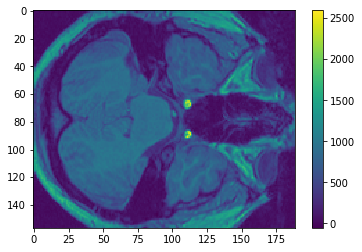

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(arr[:,:,5])
plt.colorbar()
plt.plot()

My knowledge of neurology is severely limited, but I'm pretty sure those are eye sockets on the right!

If you look at the colorbar, you'll realize that there are very few points that reach the top values (larger than, say, 1500). We can confirm that insight by making a histogram:

(BTW, we're using the default [Viridis](https://bids.github.io/colormap/) colorscheme, which was designed to solve a number of ergonomic problems with Jet, the former default. [There's an interesting talk about its design process (video)](https://www.youtube.com/watch?v=xAoljeRJ3lU).)

/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


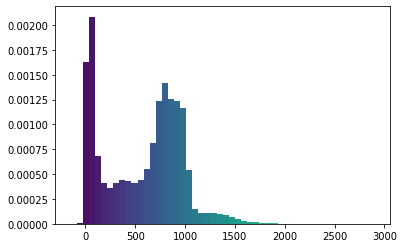

In [5]:
import numpy as np
from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, normed=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()
    
show_histogram(arr)

I'm going to change this using a homebrewed and totally guesstimated transformation:

/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


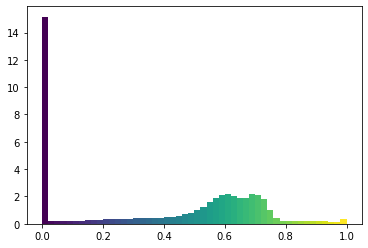

In [6]:
def scale_by(arr, fac):
    mean = np.mean(arr)
    return (arr-mean)*fac + mean

transformed = np.clip(scale_by(np.clip(normalize(arr)-0.1, 0, 1)**0.4, 2)-0.1, 0, 1)
show_histogram(transformed)

The range of colors is more uniform, with a big peak at 0 (which we'll see is a good idea).

# Plotting!

## Warmup: a pile of cubes

Matplotlib's 3D capabilities are still being developed, and they have a few quirks we'll have to work around. Let's forget our brain for a moment, and start with a very simple [voxel](https://en.wikipedia.org/wiki/Voxel) plot, to introduce basic concepts.

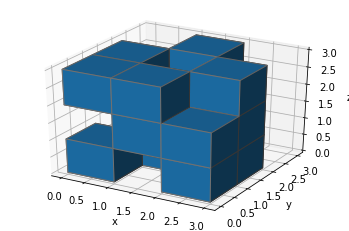

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filled = np.array([
    [[1, 0, 1], [0, 0, 1], [0, 1, 0]],
    [[0, 1, 1], [1, 0, 0], [1, 0, 1]],
    [[1, 1, 0], [1, 1, 1], [0, 0, 0]]
])

ax = make_ax(True)
ax.voxels(filled, edgecolors='gray')
plt.show()

So we can display some voxels easily enough (in case you don't know what they are and for some reason haven't clicked the Wikipedia link above, they're just 3D pixels, so little cubes).

Here, the `filled` array tells matplotlib which voxels to fill in. Any truthy value (you'll most likely use `True` or `1`) in the array means that the voxel in the corresponding poxition should be filled. It's in `x`-major, `z`-minor order, so the first `[1, 0, 1]` block, for instance, means "fill in the blocks at (x, y, z)=(0, 0, 0) don't fill the one at (0, 0, 1), and fill the one at (0, 0, 2)".

That's all good, but the blocks in front tend to occlude the rest. How about we make everything semi-transparent? We can do this by specifying an HTML color with an alpha component.

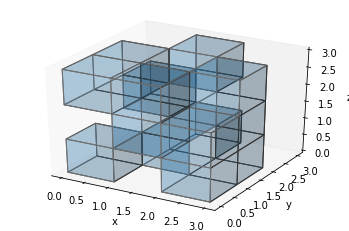

In [8]:
ax = make_ax()
ax.voxels(filled, facecolors='#1f77b430', edgecolors='gray')
plt.show()

That seems to work (although it's a bit messy), but there's a problem. Look at what happens if we display a solid block:

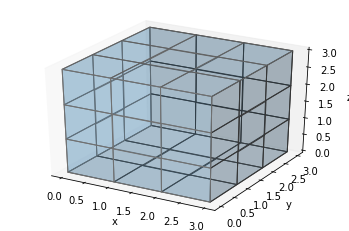

In [9]:
ax = make_ax()
ax.voxels(np.ones((3, 3, 3)), facecolors='#1f77b430', edgecolors='gray')
plt.show()

Only the faces and edges on the sides are rendered. This seems okay, but what if we want to color the middle voxel red, it's not going to show:

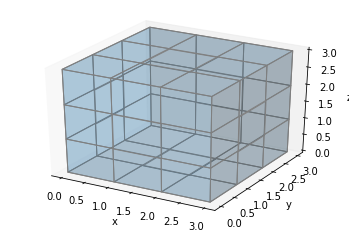

In [10]:
ax = make_ax()
colors = np.array([[['#1f77b430']*3]*3]*3)
colors[1,1,1] = '#ff0000ff'
ax.voxels(np.ones((3, 3, 3)), facecolors=colors, edgecolor='gray')
plt.show()

To solve this, we can add extra voxels in between. Let's define a helper function, `explode`, which will take our `filled` array and return an array twice as large in each dimension, with an extra space between each voxel:

In [11]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

(Note that the function supports arrays of more than three dimensions, and will stick any extra dimensions back at the end. This is because we'll later use explode on 4D arrays.)

Let's plot the exploded version, without the borders for better visibility:

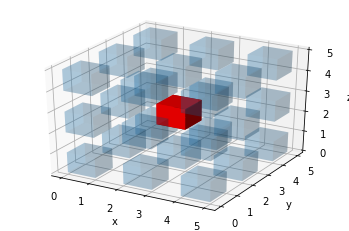

In [12]:
ax = make_ax(True)
colors = np.array([[['#1f77b430']*3]*3]*3)
colors[1,1,1] = '#ff0000ff'
colors = explode(colors)
filled = explode(np.ones((3, 3, 3)))
ax.voxels(filled, facecolors=colors)
plt.show()

This works, but we don't want these gaps between the voxels.

Fortunately, `voxels` supports one (or rather three) other arguments, `x`, `y` and `z`. These should follow the format generated by [`np.indices`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.indices.html), so they're 4-dimensional. They allow us to change the coordinates of a voxel corner. Specifically, `x[i, j, k]` is the x coordinate of the lower-bottom-left corner of the voxel at position (_i_, _j_, _k_) in the `filled` array. This also mean that if you have _m_ by _n_ by _p_ voxels, `x`, `y` and `z` all have shape (_m+1_, _n+1_, _p+1_).

Let's briefly go back to the full block example. We can extend the middle block by incrementing `y` for all blocks in the middle and back columns:

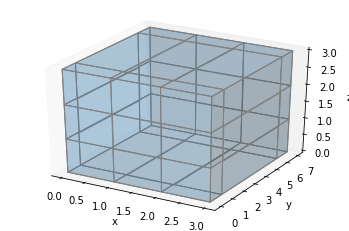

In [13]:
ax = make_ax()

filled = np.ones((3, 3, 3))
x, y, z = np.indices(np.array(filled.shape) + 1)
y[:,2:,:] += 4

ax.voxels(x, y, z, filled, facecolors='#1f77b430', edgecolor='gray')
plt.show()

Or we could change the coordinates of a specific point:

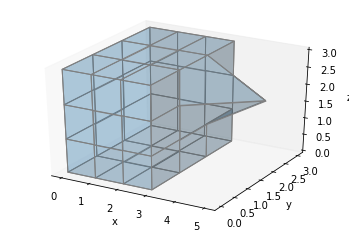

In [14]:
ax = make_ax()

filled = np.ones((3, 3, 3))
x, y, z = np.indices(np.array(filled.shape) + 1)
x[3, 2, 2] = 5

ax.voxels(x, y, z, filled, facecolors='#1f77b430', edgecolor='gray')
plt.show()

Putting all this together, we can draw over all the inserted voxels we just added by making all of the original voxels twice as large. Let's do that, and plot our red cube example again:

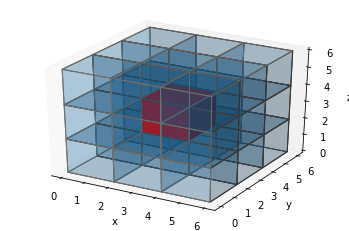

In [15]:
def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

ax = make_ax()
colors = np.array([[['#1f77b430']*3]*3]*3)
colors[1,1,1] = '#ff0000ff'
colors = explode(colors)
filled = explode(np.ones((3, 3, 3)))
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
ax.voxels(x, y, z, filled, facecolors=colors, edgecolors='gray')
plt.show()

## Serious business

An important note: `voxels` is slow on large 3D data. I've resized all the brain data to be 50×50×50 voxels, which still has a full runtime of nearly 4 minutes for the entire skull (on my admittedly not very beefy machine). If you have a powerful machine, you can set a higher image size, but remember that it scales cubically. I'm resizing using scikit-image, but there are lots of other options.

(Remember that `transformed` is our 3D data, with rescaled values.)

In [26]:
IMG_DIM = 50

from skimage.transform import resize
resized = resize(transformed, (IMG_DIM, IMG_DIM, IMG_DIM), mode='constant')

We've dealt with binary data so far, but how can we represent 3D volumetric data with a range of values? The approach I've taken is to set each voxel's transparency equal to its value. In the case of brain data, this allows to see through the black areas corresponding to air around the head, as well as through some of the empty parts inside the brain. Of course, you can't see much trough the brain itself—but the image would be incredibly confusing otherwise. In any case, the technique I'm showing here allows you to adapt the color/transparency system easily should you want to implement something else (for instance, you could set the maximal transparency to a low value, which would make it possible to see through your plot much more).

I've replicated `explode` and `expand_coordinates` from above, so you can directly copy-paste the cell below to use in your project.

In [27]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors)
    plt.show()

A few notes on this implementation:

 * Instead of colors as strings, I'm using a 4D colors array, where the last dimension (of size 4) holds the red, green, blue, and alpha (transparency) values. Doing `facecolors[:,:,:,-1] = cube` makes the alpha equal to the voxel value.
 * I'm still using Viridis, the default color map. You can use [any map you like](https://matplotlib.org/users/colormaps.html) that's supported by matplotlib, by changing the call to `cm.viridis`.
 * I'm setting some axis limits to make sure that all the plots are on the same scales, even if I truncate the image to show a cross-section.
 * You can add a call to `ax.set_axis_off()` if you want to remove the background and axis ticks.

Oh, and if you were wondering, this is where `explode` handling 4D arrays comes in handy.


## Results

So first, a cut view of the skull:

In [28]:
resized.shape

(50, 50, 50)

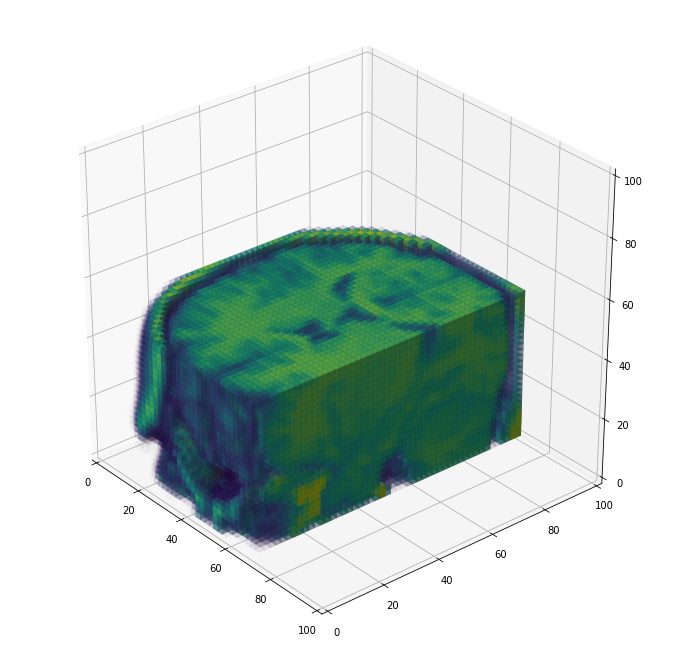

In [29]:
plot_cube(resized[:35,::-1,:25])

(I'm plotting the y-axis backwards so that the eyes are in front).

A view from the back, cutting through in diagonal:

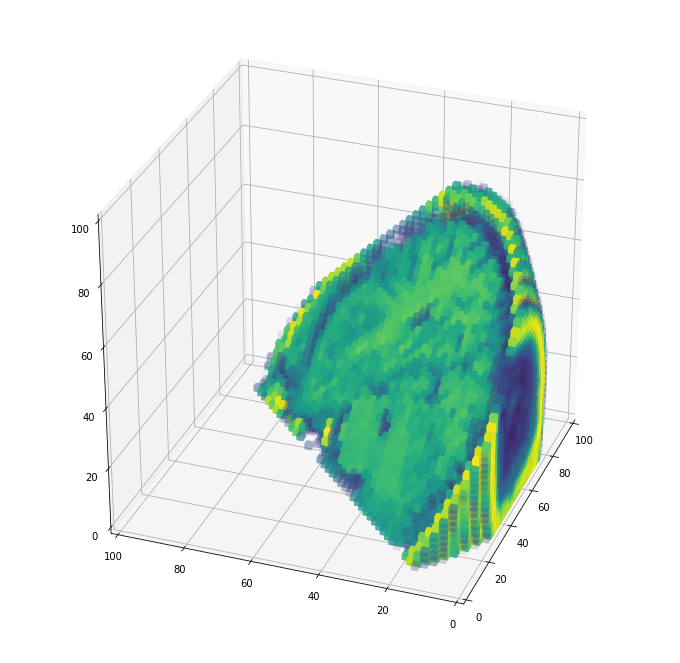

In [19]:
cube = np.copy(resized)

for x in range(0, IMG_DIM):
    for y in range(0, IMG_DIM):
        for z in range(max(x-y+5, 0), IMG_DIM):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)

And a full view, where you can see the nasal cavity and make out the eye sockets at the very bottom:

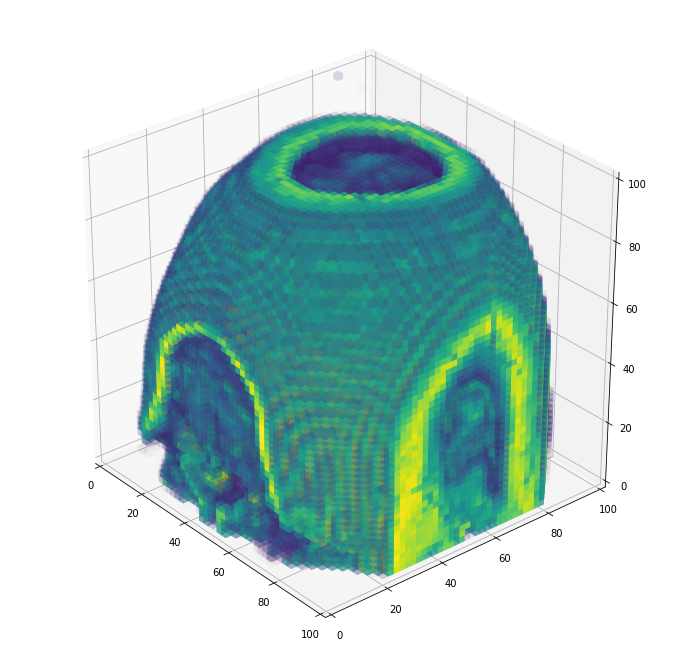

In [20]:
plot_cube(resized[:,::-1,:])

I hope you enjoyed this tutorial! Feel free to drop me suggestions for improvements, questions, or other random notes below. You can also look at [`voxel`'s documentation](https://matplotlib.org/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D.voxels) for more details.

Here are the library versions I've used for this tutorial:

    matplotlib==2.1.0
    nibabel==2.2.1
    numpy==1.13.3
    requests==2.18.4
    scikit-image==0.13.1

You can also [download the notebook](/content-static/matplotlib-3d/matplotlib-3d.ipynb).

[^1]: Büchel, Christian, and K. J. Friston. "Modulation of connectivity in visual pathways by attention: cortical interactions evaluated with structural equation modelling and fMRI." _Cerebral cortex (New York, NY: 1991)_ 7.8 (1997): 768-778.